# CLIP-Cues: Linear Model - Inference Example

This notebook demonstrates how to use pre-trained linear classification models to detect synthetic (AI-generated) images.

## Overview

We'll cover:
1. Loading a pre-trained linear model
2. Running inference on sample images
3. Comparing performance across different training datasets
4. Understanding the pure linear approach

The linear models use the simplest possible architecture: a single linear layer (CLIP features → logits) with only 1,025 parameters, making it the most efficient baseline.

## Setup

First, install the required package if you haven't already:

```bash
pip install clip-cues
```

In [1]:
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

from clip_cues import (
    SyntheticImageClassifierInference,
    CLIPLargePatch14,
    LinearHead,
)
from clip_cues.transforms import Transforms

## Load Feature Extractor and Transforms

We use CLIP ViT-L/14 as the feature extractor, frozen to preserve its pre-trained vision-language knowledge.

In [2]:
# Load CLIP feature extractor
extractor = CLIPLargePatch14(cache_dir="../hf_cache")
extractor.freeze()

# Setup image transforms
transforms = Transforms(extractor.transforms)
inference_transforms = transforms.get_inference_transforms()

print(f"Feature extractor output dimension: {extractor.output_dim}")

Feature extractor output dimension: 1024


## Load Linear Classification Head

The `LinearHead` is the simplest possible classifier:
- Input: 1024-dimensional CLIP features
- Output: Single logit for binary classification
- No hidden layers, no non-linearities

This pure linear approach tests how well CLIP features alone can discriminate synthetic images.

In [3]:
# Initialize the linear classification head
# Architecture: 1024 -> 1 (direct linear projection)
head = LinearHead(
    input_dim=extractor.output_dim,  # 1024 for CLIP ViT-L/14
    num_classes=1,  # Binary classification (synthetic vs real)
)

print(f"Linear head architecture: {extractor.output_dim} -> 1")
print(f"Total parameters in classification head: {sum(p.numel() for p in head.parameters()):,}")
print(f"\nModel structure:")
print(head)

Linear head architecture: 1024 -> 1
Total parameters in classification head: 1,025

Model structure:
LinearHead(
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)


## Create Inference Model and Load Weights

Available pre-trained linear probe models:
- `linear_probe_cnnspot.ckpt` - Trained on CNNSpot dataset
- `linear_probe_synthbuster.ckpt` - Trained on SynthBuster+ dataset
- `linear_probe_synthclic.ckpt` - Trained on SynthCLIC dataset
- `linear_probe_combined.ckpt` - Trained on combined datasets (recommended)

In [ ]:
# Create the full inference model
model = SyntheticImageClassifierInference(extractor.model, head)

# Load pre-trained weights
checkpoint_path = "../data/checkpoints/linear_probe_combined.ckpt"

# Check if checkpoint exists
if Path(checkpoint_path).exists():
    checkpoint = torch.load(checkpoint_path, weights_only=True)

    # Remove "model." prefix from state dict keys
    weights = {k.replace("model.", ""): v for k, v in checkpoint["state_dict"].items()}

    # Load weights
    model.load_state_dict(weights, strict=False)
    print("✓ Pre-trained weights loaded successfully")
    print(f"  Checkpoint: {Path(checkpoint_path).name}")
    print(f"  Model type: {checkpoint.get('model_type', 'unknown')}")
else:
    print(f"⚠ Checkpoint not found at {checkpoint_path}")
    print("Please download pre-trained checkpoints from the repository")

# Set model to evaluation mode
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"\nModel running on: {device}")

✓ Pre-trained weights loaded successfully
  Checkpoint: linear_probe_combined.ckpt
  Model type: linear

Model running on: cuda


## Inference on a Single Image

Let's test the linear model on a sample image.

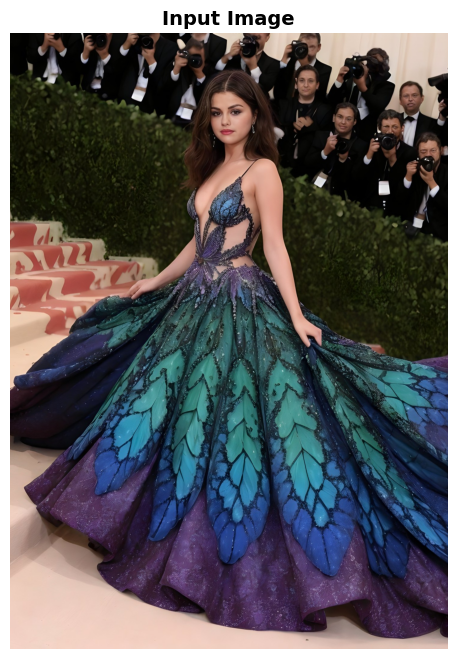


Prediction Results
Synthetic probability: 0.736
Real probability:      0.264

Prediction: SYNTHETIC
Confidence: 73.6%


In [ ]:
# Load an image (replace with your own image path)
image_path = "../examples/images/synthetic2.jpg"

if Path(image_path).exists():
    # Load and display the image
    image = Image.open(image_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image', fontsize=14, fontweight='bold')
    plt.show()

    # Prepare the image for inference
    batch = inference_transforms({"image": [image]})
    pixel_values = torch.stack(batch["pixel_values"]).to(device)

    # Run inference
    with torch.no_grad():
        prob = model(pixel_values)

    # Display results
    synthetic_prob = prob.item()
    real_prob = 1 - synthetic_prob

    print(f"\n{'='*50}")
    print(f"Prediction Results")
    print(f"{'='*50}")
    print(f"Synthetic probability: {synthetic_prob:.3f}")
    print(f"Real probability:      {real_prob:.3f}")
    print(f"\nPrediction: {'SYNTHETIC' if synthetic_prob > 0.5 else 'REAL'}")
    print(f"Confidence: {max(synthetic_prob, real_prob):.1%}")
    print(f"{'='*50}")
else:
    print(f"⚠ Image not found at {image_path}")
    print("Please provide a valid image path")

## Batch Inference on Multiple Images

Process multiple images at once for efficiency.

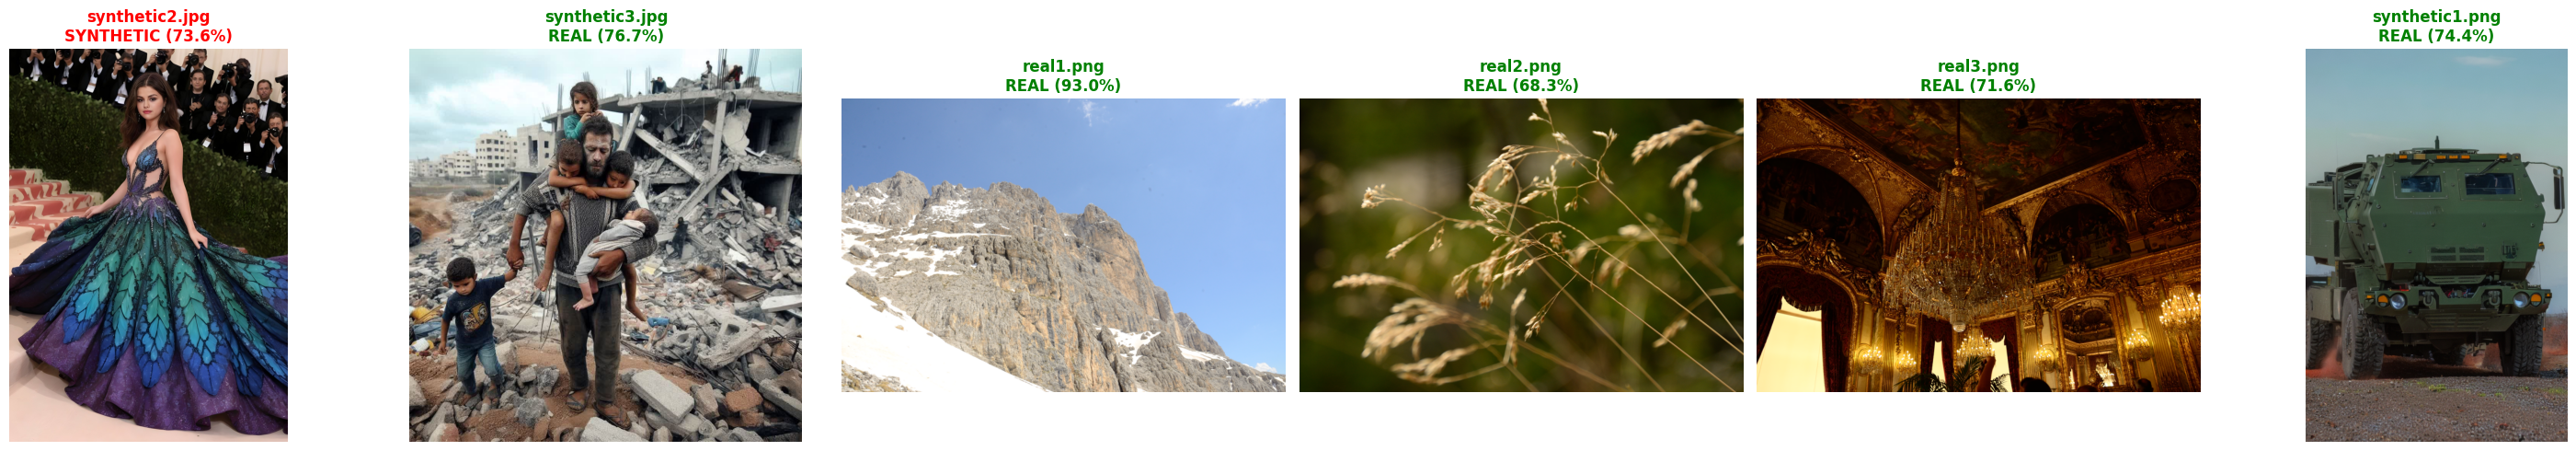


Detailed Results:
synthetic2.jpg                 | Synthetic: 0.736 | SYNTHETIC
synthetic3.jpg                 | Synthetic: 0.233 | REAL     
real1.png                      | Synthetic: 0.070 | REAL     
real2.png                      | Synthetic: 0.317 | REAL     
real3.png                      | Synthetic: 0.284 | REAL     
synthetic1.png                 | Synthetic: 0.256 | REAL     


In [ ]:
# Example: Process multiple images from a directory
image_dir = Path("../examples/images/")

if image_dir.exists():
    # Load all images
    image_paths = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

    if image_paths:
        images = [Image.open(p) for p in image_paths]

        # Transform all images
        batch = inference_transforms({"image": images})
        pixel_values = torch.stack(batch["pixel_values"]).to(device)

        # Run batch inference
        with torch.no_grad():
            probs = model(pixel_values)

        # Display results
        fig, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5))
        if len(images) == 1:
            axes = [axes]

        for idx, (img_path, img, prob) in enumerate(zip(image_paths, images, probs)):
            axes[idx].imshow(img)
            axes[idx].axis('off')

            synthetic_prob = prob.item()
            prediction = "SYNTHETIC" if synthetic_prob > 0.5 else "REAL"
            confidence = max(synthetic_prob, 1 - synthetic_prob)

            color = 'red' if prediction == "SYNTHETIC" else 'green'
            axes[idx].set_title(
                f"{img_path.name}\n{prediction} ({confidence:.1%})",
                color=color,
                fontweight='bold'
            )

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("\nDetailed Results:")
        print(f"{'='*70}")
        for img_path, prob in zip(image_paths, probs):
            synthetic_prob = prob.item()
            print(f"{img_path.name:30} | Synthetic: {synthetic_prob:.3f} | {('SYNTHETIC' if synthetic_prob > 0.5 else 'REAL'):9}")
        print(f"{'='*70}")
    else:
        print("No images found in the directory")
else:
    print(f"Directory {image_dir} not found")
    print("Create an 'examples/images' folder and add some images to test batch inference")

## Compare Models Trained on Different Datasets

Let's compare how models trained on different datasets perform on the same image.


Comparing predictions across different training datasets:
cnnspot         | Synth: 0.129 | REAL      | Conf: 87.1%
synthbuster     | Synth: 0.841 | SYNTHETIC | Conf: 84.1%
synthclic       | Synth: 0.697 | SYNTHETIC | Conf: 69.7%
combined        | Synth: 0.736 | SYNTHETIC | Conf: 73.6%


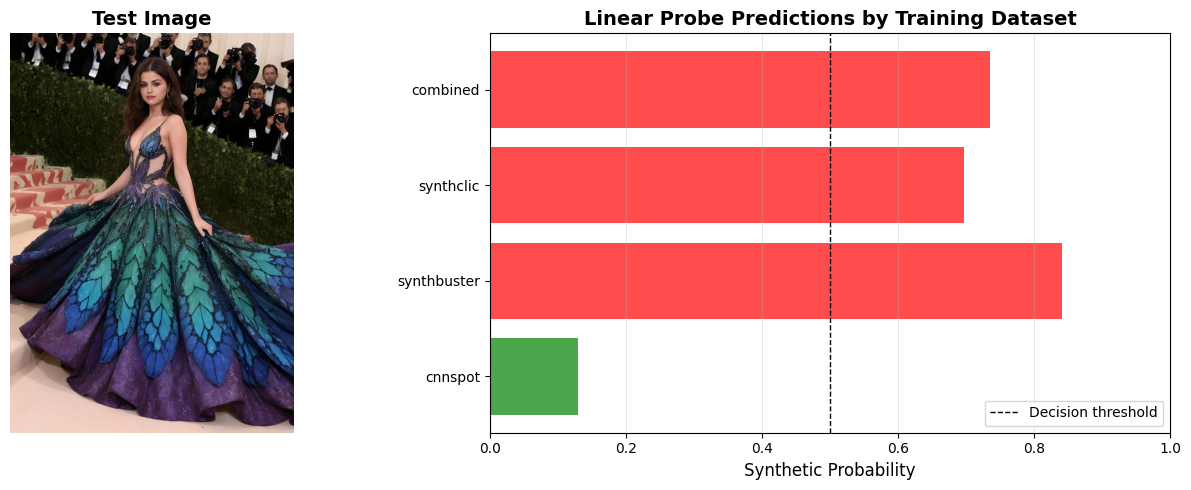


Summary Statistics:
  Mean synthetic probability: 0.601
  Std deviation: 0.277
  Min: 0.129 | Max: 0.841
  Agreement: 1/4 models agree


In [ ]:
# Test image path
test_image_path = "../examples/images/synthetic2.jpg"

if Path(test_image_path).exists():
    # Load and prepare test image
    test_image = Image.open(test_image_path)
    batch = inference_transforms({"image": [test_image]})
    pixel_values = torch.stack(batch["pixel_values"]).to(device)

    # List of checkpoints to compare
    checkpoint_names = [
        "linear_probe_cnnspot.ckpt",
        "linear_probe_synthbuster.ckpt",
        "linear_probe_synthclic.ckpt",
        "linear_probe_combined.ckpt"
    ]

    results = []

    print(f"\nComparing predictions across different training datasets:")
    print(f"{'='*70}")

    for ckpt_name in checkpoint_names:
        checkpoint_path = f"../data/checkpoints/{ckpt_name}"

        if Path(checkpoint_path).exists():
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, weights_only=True)
            weights = {k.replace("model.", ""): v for k, v in checkpoint["state_dict"].items()}

            # Load weights into model
            model.load_state_dict(weights, strict=False)
            model.eval()

            # Run inference
            with torch.no_grad():
                prob = model(pixel_values)

            synthetic_prob = prob.item()
            prediction = "SYNTHETIC" if synthetic_prob > 0.5 else "REAL"
            confidence = max(synthetic_prob, 1 - synthetic_prob)

            # Store results
            dataset_name = ckpt_name.replace("linear_probe_", "").replace(".ckpt", "")
            results.append({
                "dataset": dataset_name,
                "synthetic_prob": synthetic_prob,
                "prediction": prediction,
                "confidence": confidence
            })

            print(f"{dataset_name:15} | Synth: {synthetic_prob:.3f} | {prediction:9} | Conf: {confidence:.1%}")

    print(f"{'='*70}")

    # Visualize comparison
    if results:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Display the test image
        ax1.imshow(test_image)
        ax1.axis('off')
        ax1.set_title('Test Image', fontsize=14, fontweight='bold')

        # Bar plot of synthetic probabilities
        datasets = [r["dataset"] for r in results]
        probs = [r["synthetic_prob"] for r in results]
        colors = ['red' if p > 0.5 else 'green' for p in probs]

        y_pos = np.arange(len(datasets))
        ax2.barh(y_pos, probs, color=colors, alpha=0.7)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(datasets)
        ax2.set_xlabel('Synthetic Probability', fontsize=12)
        ax2.set_title('Linear Probe Predictions by Training Dataset', fontsize=14, fontweight='bold')
        ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='Decision threshold')
        ax2.set_xlim([0, 1])
        ax2.grid(axis='x', alpha=0.3)
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # Summary statistics
        probs_array = np.array(probs)
        print(f"\nSummary Statistics:")
        print(f"  Mean synthetic probability: {probs_array.mean():.3f}")
        print(f"  Std deviation: {probs_array.std():.3f}")
        print(f"  Min: {probs_array.min():.3f} | Max: {probs_array.max():.3f}")
        print(f"  Agreement: {len([p for p in probs if (p > 0.5) == (probs[0] > 0.5)])}/{len(probs)} models agree")
else:
    print(f"Test image not found at {test_image_path}")

## Helper Function for Easy Inference

In [ ]:
def predict_image(image_path_or_pil, threshold=0.5):
    """
    Predict whether an image is synthetic or real using the linear model.

    Args:
        image_path_or_pil: Path to image file or PIL Image object
        threshold: Classification threshold (default: 0.5)

    Returns:
        dict: Prediction results with probabilities and label
    """
    # Load image if path is provided
    if isinstance(image_path_or_pil, (str, Path)):
        image = Image.open(image_path_or_pil)
    else:
        image = image_path_or_pil

    # Transform and prepare for inference
    batch = inference_transforms({"image": [image]})
    pixel_values = torch.stack(batch["pixel_values"]).to(device)

    # Run inference
    with torch.no_grad():
        prob = model(pixel_values)

    synthetic_prob = prob.item()
    real_prob = 1 - synthetic_prob

    return {
        "synthetic_probability": synthetic_prob,
        "real_probability": real_prob,
        "prediction": "synthetic" if synthetic_prob > threshold else "real",
        "confidence": max(synthetic_prob, real_prob)
    }

# Example usage
# result = predict_image("path/to/image.jpg")
# print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.1%})")

## Understanding the LinearHead Model

### Architecture

The `LinearHead` uses the simplest possible architecture:
```
CLIP Features (1024) → Linear(1) → Sigmoid
```

With only 1,025 trainable parameters (1024 weights + 1 bias), this is the minimal baseline.

### Why Pure Linear?

The linear probe tests a fundamental hypothesis:
- Can CLIP's pre-trained features alone discriminate synthetic images?
- Do we need any additional feature transformation?
- What is the minimal capacity needed for this task?

### Advantages

1. **Maximum Efficiency**: Absolute minimum parameters and computation
2. **Fast Inference**: Single matrix multiplication
3. **Easy to Interpret**: Weights show which CLIP features are most important
4. **No Overfitting**: Very limited capacity prevents memorization
5. **Strong Baseline**: Tests the quality of CLIP features directly

### Model Comparison

| Model | Parameters | Architecture |
|-------|-----------|--------------|
| **LinearHead** | ~1K | 1024 → 1 |
| **ActivationOrthogonalityHead** | ~8K | 1024 → 8 → 1 |
| **Concept Bottleneck** | ~1M | 1024 → concepts → 1 |

### When to Use LinearHead

- Need absolute maximum speed and minimum memory
- Want to understand CLIP feature importance
- Establishing a baseline for comparison
- Deploying on extremely resource-constrained devices

### Limitations

- No feature transformation may limit performance
- No interpretability beyond feature weights
- Cannot learn complex decision boundaries
- May underperform vs. models with hidden layers

## Analyzing Feature Weights

Since the linear model is just a single weight vector, we can visualize which CLIP features are most important for distinguishing synthetic from real images.

# Get the linear layer weights
weights = model.classification_head.fc.weight.data.cpu().numpy().flatten()
bias = model.classification_head.fc.bias.data.cpu().numpy()[0]

print(f"Linear layer weights shape: {weights.shape}")
print(f"Bias: {bias:.4f}")

# Analyze weight statistics
print(f"\nWeight statistics:")
print(f"  Mean: {weights.mean():.4f}")
print(f"  Std: {weights.std():.4f}")
print(f"  Min: {weights.min():.4f} | Max: {weights.max():.4f}")
print(f"  Positive: {(weights > 0).sum()} | Negative: {(weights < 0).sum()}")

# Visualize weight distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of weights
ax1.hist(weights, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax1.set_xlabel('Weight Value', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Linear Weights', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Top positive and negative weights
n_top = 20
top_pos_idx = np.argsort(weights)[-n_top:]
top_neg_idx = np.argsort(weights)[:n_top]
top_indices = np.concatenate([top_neg_idx, top_pos_idx])
top_weights = weights[top_indices]

colors = ['green' if w < 0 else 'red' for w in top_weights]
y_pos = np.arange(len(top_weights))

ax2.barh(y_pos, top_weights, color=colors, alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([f'Feat {i}' for i in top_indices], fontsize=8)
ax2.set_xlabel('Weight Value', fontsize=12)
ax2.set_title(f'Top {n_top} Features (Green=Real, Red=Synthetic)', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"  Features with positive weights push toward 'synthetic'")
print(f"  Features with negative weights push toward 'real'")
print(f"  Magnitude indicates importance")

## Next Steps

- Try different pre-trained checkpoints for comparison
- Compare linear probe predictions with other approaches (ActivationOrthogonality, Concept models)
- Analyze which CLIP features are most discriminative
- Fine-tune models on your own datasets
- Deploy the ultra-lightweight model in production systems
- Check the [documentation](https://github.com/marco-willi/clip-cues) for more advanced usage